In [6]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scFunctions as sf
import scFates as scf
import palantir
import pickle

sc.settings.verbosity = 3

**Loading data and preprocessing**

In [2]:
adata = sc.read_h5ad("../data/MERGED_SEU_REANOTATE.h5ad")
adata

AnnData object with n_obs × n_vars = 119960 × 25572
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new'
    var: 'features'

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 492 genes that are detected in less than 3 cells


In [4]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [5]:
adata = sf.pp_PCA(adata) # Function defined in scFunctions.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


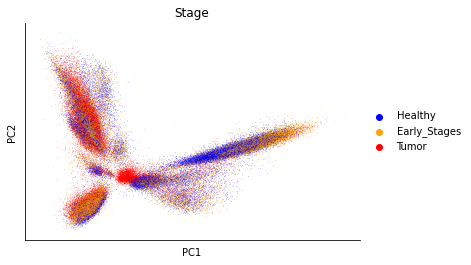

In [6]:
Stage=['Healthy','Early_Stages','Tumor']
adata.obs['Stage']=pd.Categorical(
    values=adata.obs.Stage, categories=Stage, ordered=True)

sc.pl.pca(adata, color = "Stage", palette={"Healthy" : "blue", "Early_Stages" : "orange", "Tumor" : "red"})

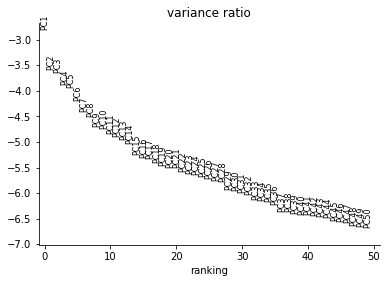

In [7]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) #ndim = 30

In [8]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packag

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:49)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


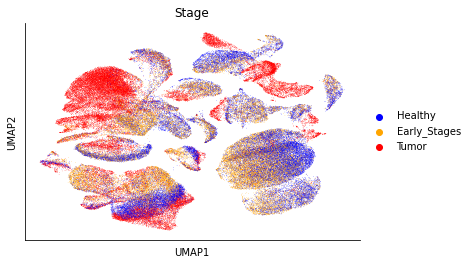

In [9]:
sc.pl.umap(adata, color = 'Stage')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


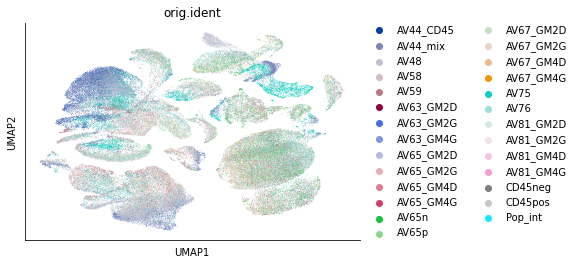

In [10]:
sc.pl.umap(adata, color = "orig.ident")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


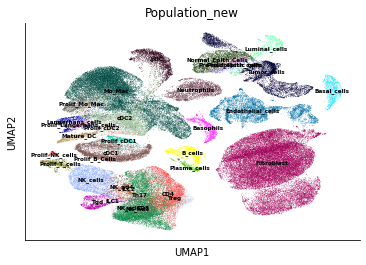

In [11]:
sc.pl.umap(adata, color = "Population_new", legend_loc = "on data", legend_fontsize = "xx-small")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


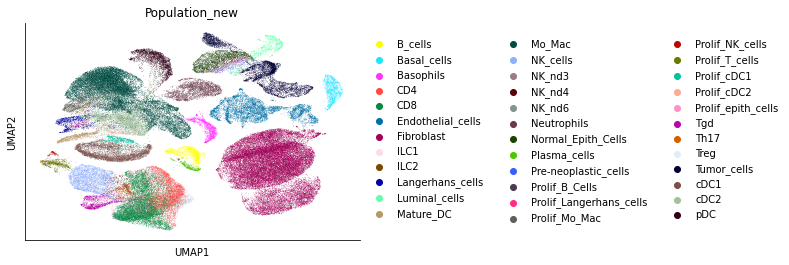

In [12]:
sc.pl.umap(adata, color = "Population_new")

## On garde uniquement les cellules épithéliales

In [13]:
list_epi = ["Normal_Epith_Cells", "Pre-neoplastic_cells", "Tumor_cells", "Prolif_epith_cells"]

adata_epi = adata[adata.obs['Population_new'].isin(list_epi), :].raw.to_adata().copy()
adata_epi

# 9948 cells

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


AnnData object with n_obs × n_vars = 9948 × 25080
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'orig.ident_colors', 'Population_new_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [14]:
adata_epi = sf.pp_PCA(adata_epi) # Function defined in scFunction.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


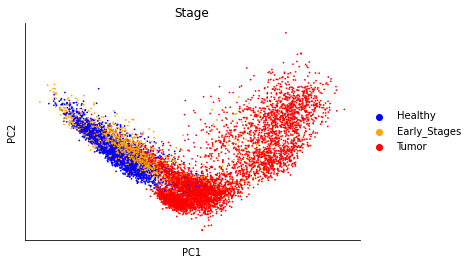

In [15]:
sc.pl.pca(adata_epi, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


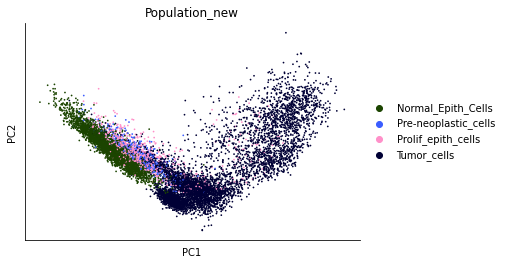

In [16]:
sc.pl.pca(adata_epi, color = "Population_new")

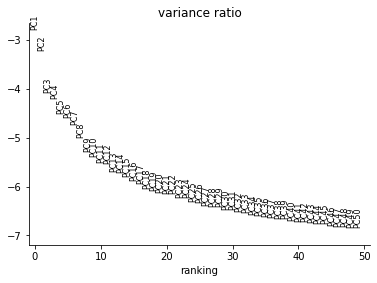

In [17]:
sc.pl.pca_variance_ratio(adata_epi, log=True, n_pcs = 50) #ndim = 30

In [18]:
sc.pp.neighbors(adata_epi, n_pcs=30, use_rep = "X_pca")
sc.tl.umap(adata_epi)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


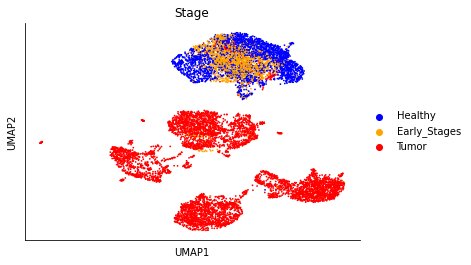

In [19]:
sc.pl.umap(adata_epi, color = 'Stage')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


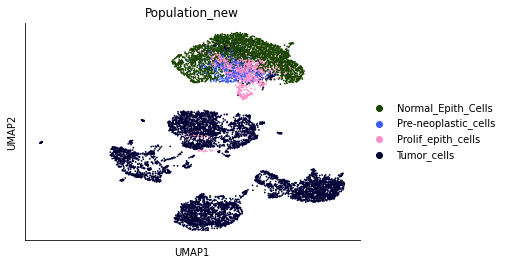

In [20]:
sc.pl.umap(adata_epi, color = 'Population_new')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


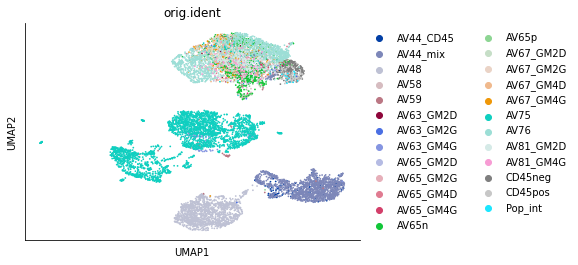

In [21]:
sc.pl.umap(adata_epi, color = 'orig.ident')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9990348  0.99839234 0.9978273  0.9951289  0.99367946
     0.9812598  0.97959983 0.9787895  0.9772934  0.9764183  0.97344947
     0.9721614  0.97010493 0.9664245 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


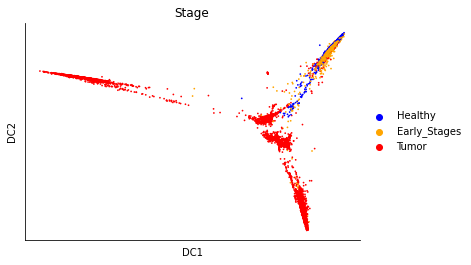

In [22]:
sc.tl.diffmap(adata_epi)
adata_epi.obsm["X_diffmap"] = adata_epi.obsm["X_diffmap"][:, 2:]
sc.pl.diffmap(adata_epi, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


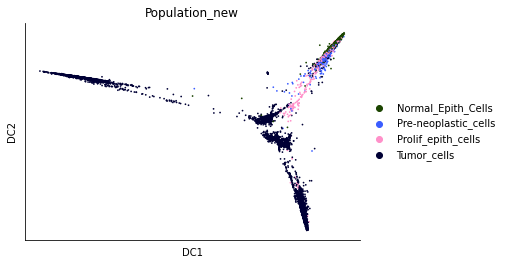

In [23]:
sc.pl.diffmap(adata_epi, color = "Population_new")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


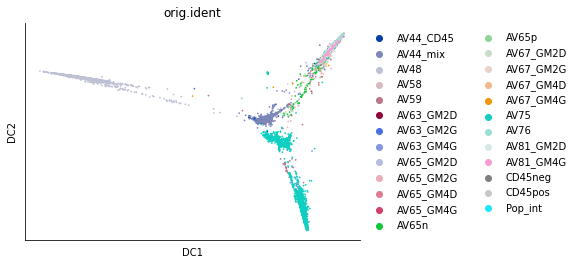

In [24]:
sc.pl.diffmap(adata_epi, color = "orig.ident")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:03)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


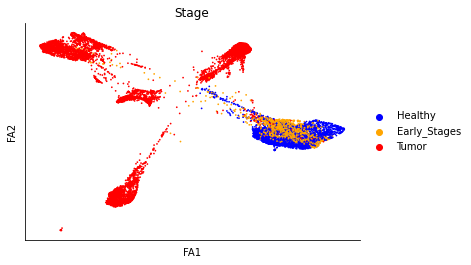

In [25]:
sc.tl.draw_graph(adata_epi)
sc.pl.draw_graph(adata_epi, color = 'Stage')

In [26]:
sc.tl.leiden(adata_epi, resolution = 0.5)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


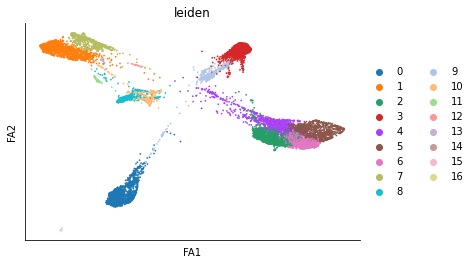

In [27]:
sc.pl.draw_graph(adata_epi, color = 'leiden')

In [28]:
sc.tl.paga(adata_epi, groups='leiden')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


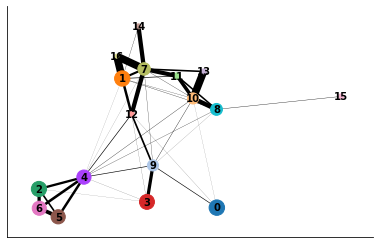

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:06)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


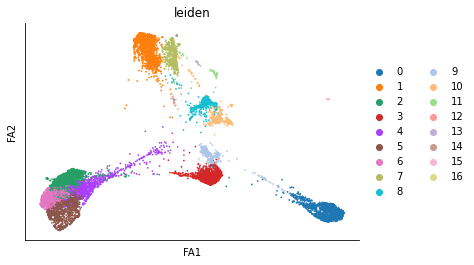

In [29]:
sc.pl.paga(adata_epi, color='leiden')
sc.tl.draw_graph(adata_epi, init_pos='paga')
sc.pl.draw_graph(adata_epi, color = 'leiden')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


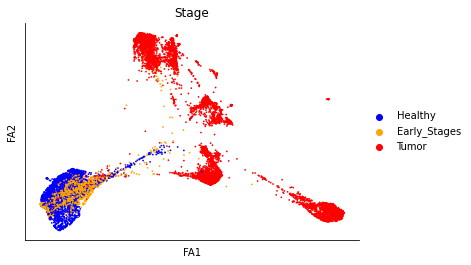

In [30]:
sc.pl.draw_graph(adata_epi, color = 'Stage')

In [31]:
adata_epi.uns['iroot'] = np.flatnonzero(adata_epi.obs['leiden']  == '6')[0]
sc.tl.dpt(adata_epi)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


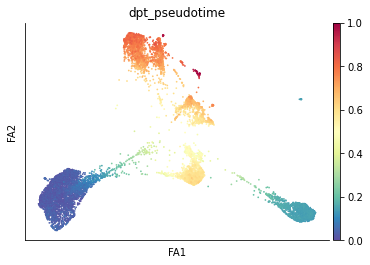

In [32]:
sc.pl.draw_graph(adata_epi, color = 'dpt_pseudotime')

In [33]:
list_epi_H_ES = ["Normal_Epith_Cells", "Pre-neoplastic_cells", "Prolif_epith_cells"]

adata_epi_H_ES = adata[adata.obs['Population_new'].isin(list_epi_H_ES), :].raw.to_adata().copy()
adata_epi_H_ES

# 4095 cells

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


AnnData object with n_obs × n_vars = 4095 × 25080
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'orig.ident_colors', 'Population_new_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [34]:
adata_epi_H_ES = sf.pp_PCA(adata_epi_H_ES) # Function defined in scFunctions.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    with n_comps=50
    finished (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


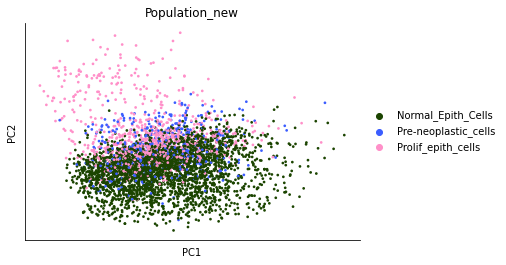

In [35]:
sc.pl.pca(adata_epi_H_ES, color = "Population_new")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


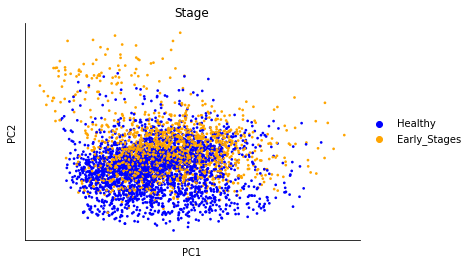

In [36]:
sc.pl.pca(adata_epi_H_ES, color = "Stage")

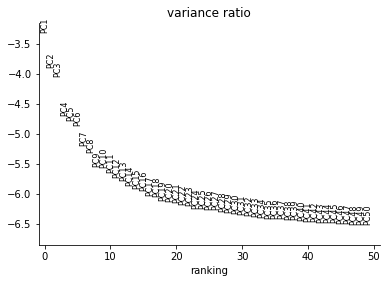

In [37]:
sc.pl.pca_variance_ratio(adata_epi_H_ES, log=True, n_pcs = 50) #ndim = 30

In [38]:
sc.pp.neighbors(adata_epi_H_ES, n_pcs=30)
sc.tl.umap(adata_epi_H_ES)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


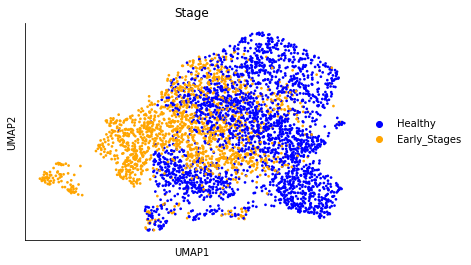

In [39]:
sc.pl.umap(adata_epi_H_ES, color = 'Stage')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


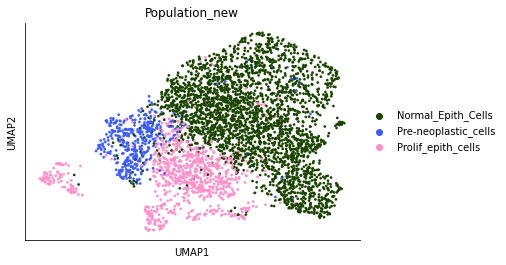

In [40]:
sc.pl.umap(adata_epi_H_ES, color = 'Population_new')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


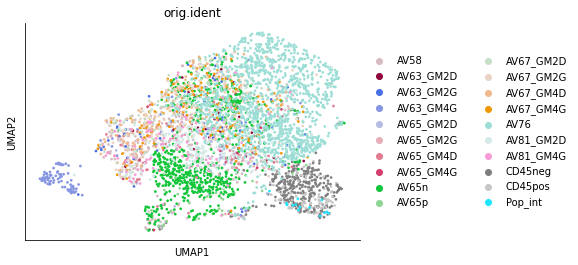

In [41]:
sc.pl.umap(adata_epi_H_ES, color = 'orig.ident')

In [42]:
sc.tl.leiden(adata_epi_H_ES, resolution=0.5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


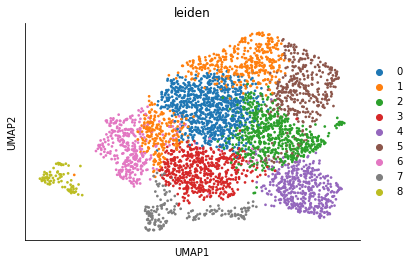

In [43]:
sc.pl.umap(adata_epi_H_ES, color = 'leiden')

/Users/mscavino/Thèse/ITMO/scripts/scFunctions.py:27: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  props = sizes.groupby(level=1).apply(lambda x: 100 * x / x.sum()).reset_index()


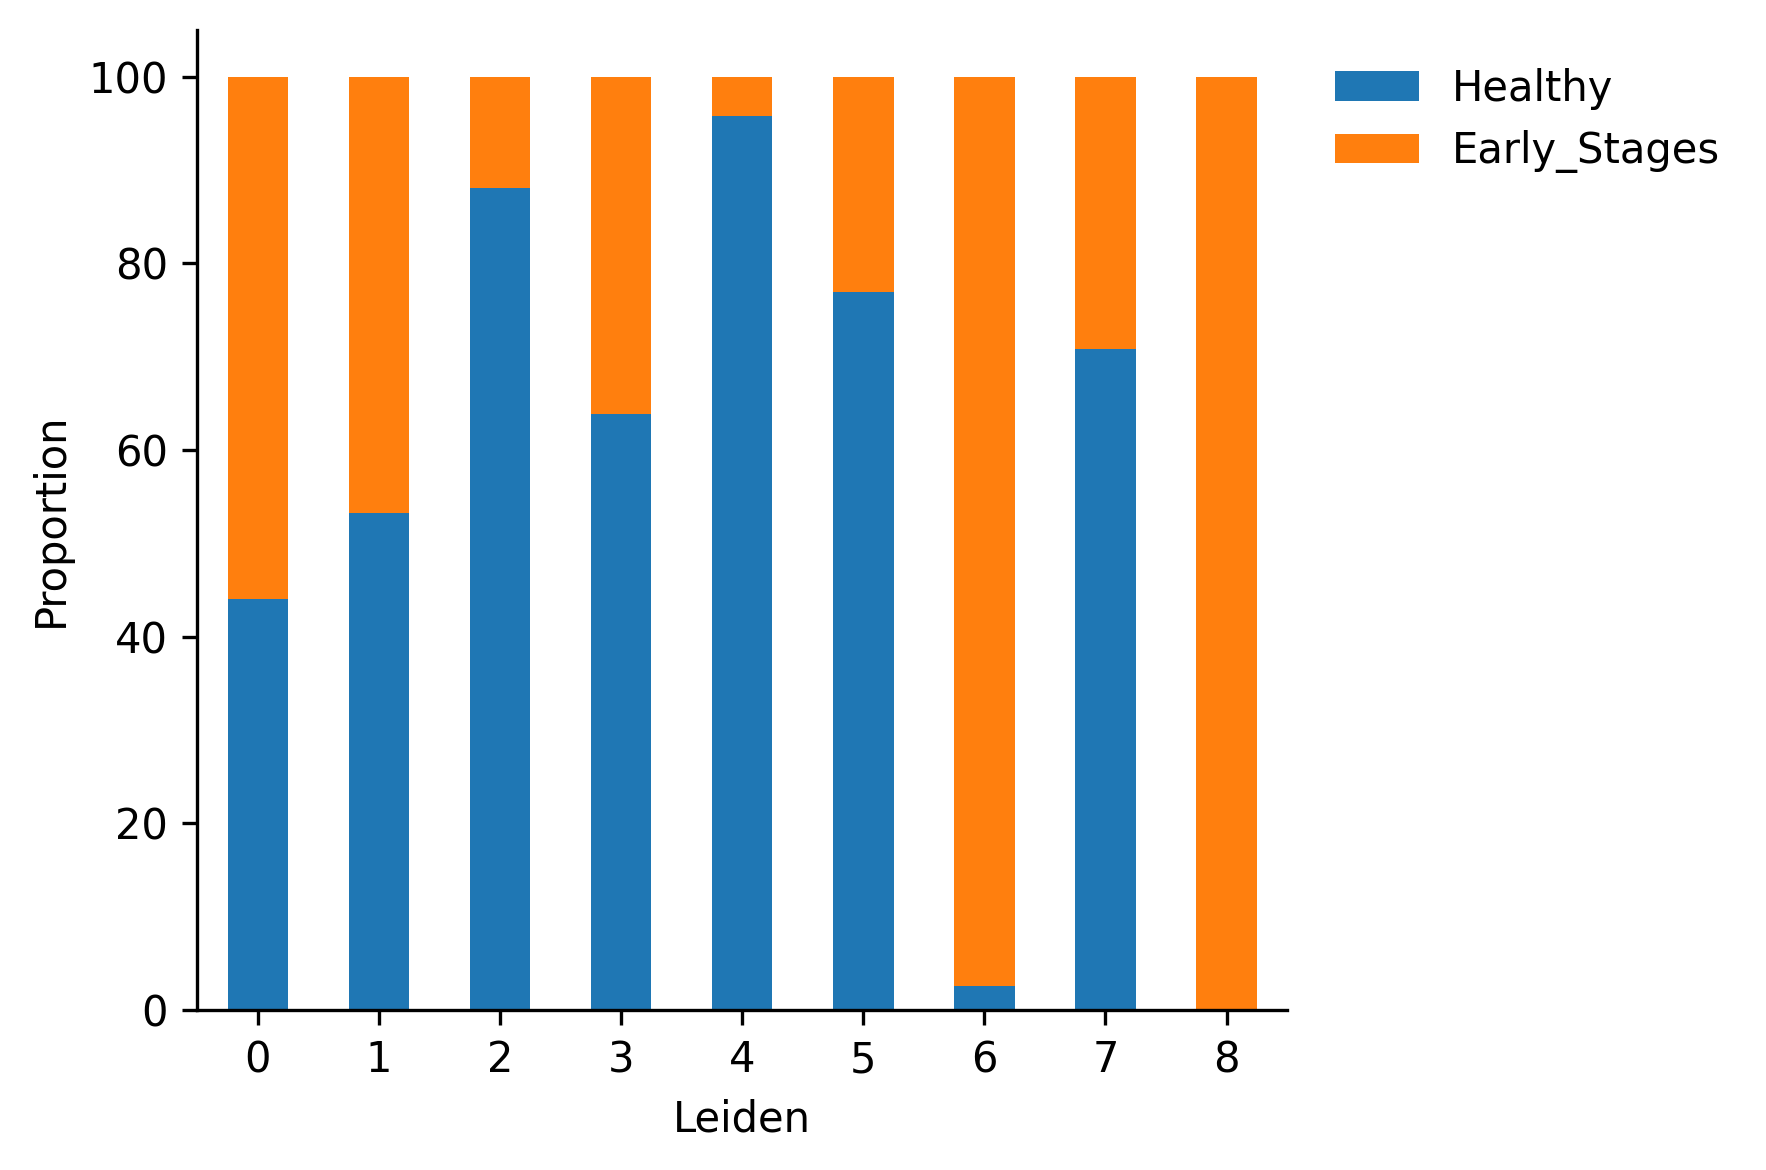

In [44]:
Stage_by_cluster = sf.get_cluster_proportions(adata_epi_H_ES, cluster_key="Stage", sample_key="leiden")
fig = sf.plot_cluster_proportions(Stage_by_cluster)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


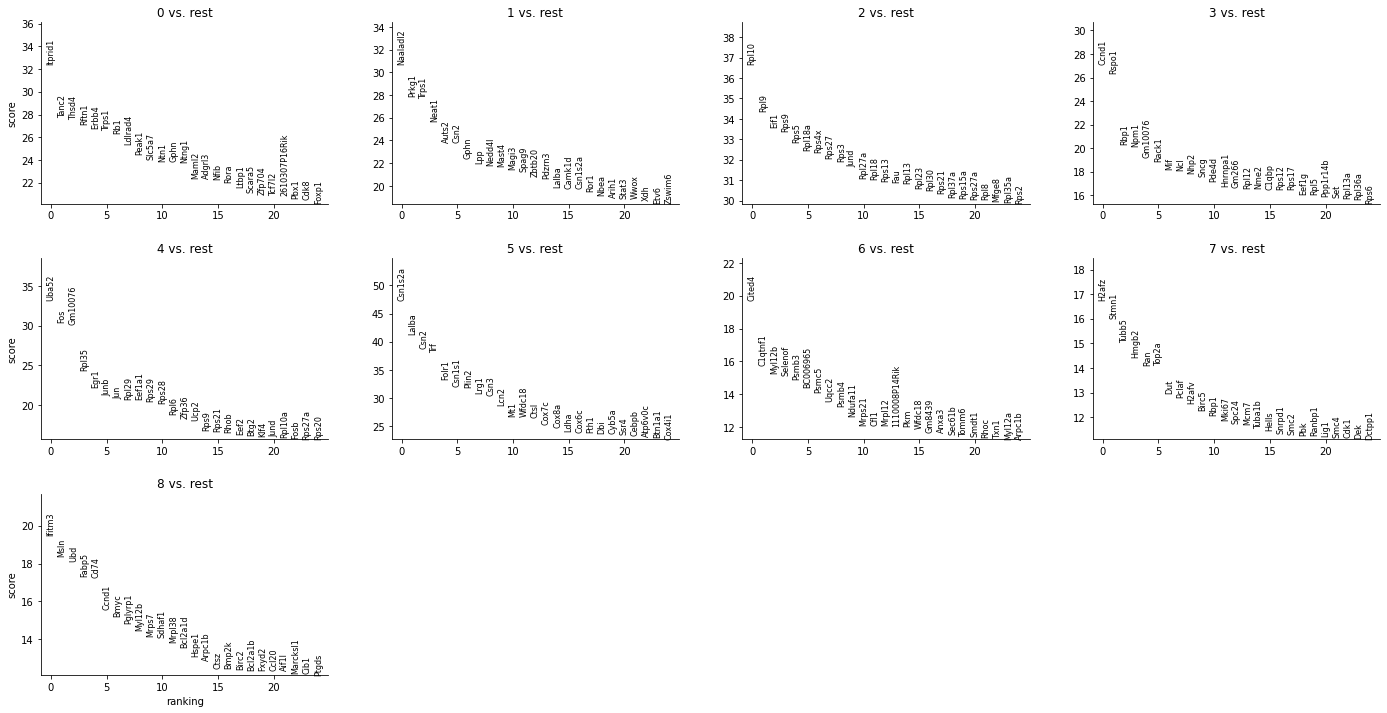

In [45]:
sc.tl.rank_genes_groups(adata_epi_H_ES, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata_epi_H_ES, n_genes=25, sharey=False)

In [46]:
df = sc.get.rank_genes_groups_df(adata_epi_H_ES, group="3", pval_cutoff = 0.01)

In [47]:
df.sort_values("logfoldchanges", ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj
1201,Cryba4,3.789426,3.688407,1.674209e-04,1.494808e-03
1435,Tnmd,3.350497,2.973807,8.608815e-04,6.167069e-03
1537,Pdf,3.197978,2.454483,1.459678e-03,9.689976e-03
1,Rspo1,26.336246,2.380562,1.020179e-103,6.396520e-100
558,2010204K13Rik,5.648548,2.339679,2.540997e-08,5.497825e-07
...,...,...,...,...,...
3232,Saa3,-5.746994,-22.982521,9.850945e-09,2.279167e-07
3481,Ifit3b,-7.061321,-23.012676,1.975684e-12,7.611391e-11
3426,Mmp7,-6.611942,-23.109379,4.361868e-11,1.448949e-09
3484,Gja4,-7.069383,-23.646170,1.865751e-12,7.243504e-11


In [48]:
sc.pp.neighbors(adata_epi_H_ES, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [49]:
sc.tl.draw_graph(adata_epi_H_ES)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:22)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


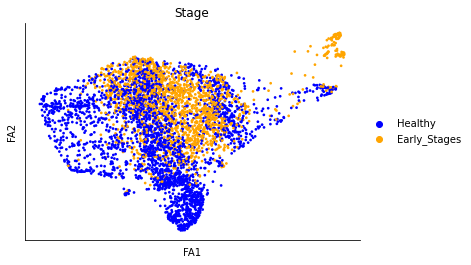

In [50]:
sc.pl.draw_graph(adata_epi_H_ES, color = "Stage")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9853223  0.97298443 0.97062993 0.963996   0.95066583
     0.9440381  0.9324112  0.9320334  0.92946446 0.92769545 0.92071974
     0.91598856 0.91342765 0.9034474 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


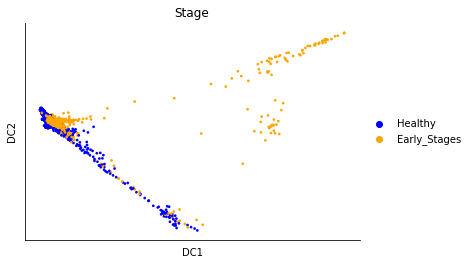

In [51]:
sc.tl.diffmap(adata_epi_H_ES)
adata_epi_H_ES.obsm["X_diffmap"] = adata_epi_H_ES.obsm["X_diffmap"][:, 1:]
sc.pl.diffmap(adata_epi_H_ES, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


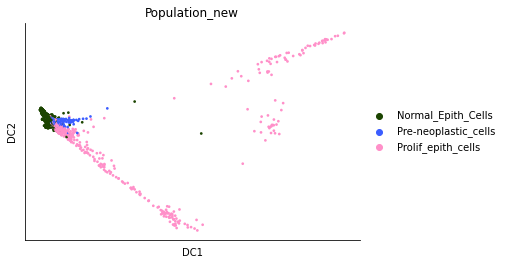

In [52]:
sc.pl.diffmap(adata_epi_H_ES, color = "Population_new")

**Sans les prolif**

In [53]:
list_epi2 = ["Normal_Epith_Cells", "Pre-neoplastic_cells", "Tumor_cells"]

adata_epi2 = adata[adata.obs['Population_new'].isin(list_epi2), :].raw.to_adata().copy()
adata_epi2

# 9948 cells

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


AnnData object with n_obs × n_vars = 9080 × 25080
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population_new', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'Stage_colors', 'neighbors', 'umap', 'orig.ident_colors', 'Population_new_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [54]:
adata_epi2 = sf.pp_PCA(adata_epi2) # Function defined in scFunction.py

# Normalize, Log-transform, select HVG, scale data and perform PCA

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


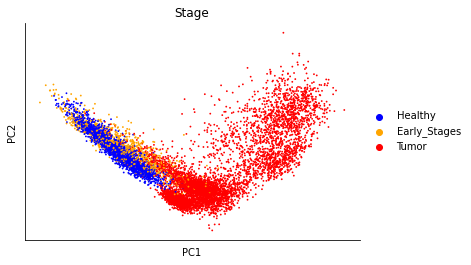

In [55]:
sc.pl.pca(adata_epi2, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


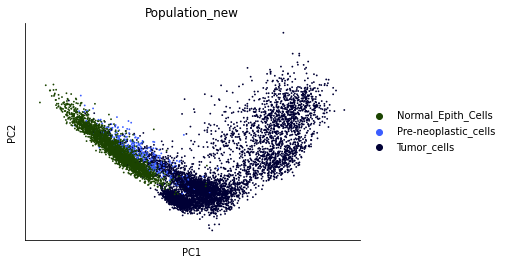

In [56]:
sc.pl.pca(adata_epi2, color = "Population_new")

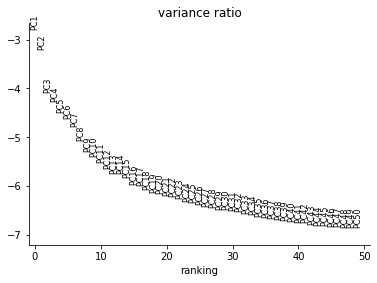

In [57]:
sc.pl.pca_variance_ratio(adata_epi2, log=True, n_pcs = 50) #ndim = 30

In [58]:
sc.pp.neighbors(adata_epi2, n_pcs=30)
sc.tl.umap(adata_epi2)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


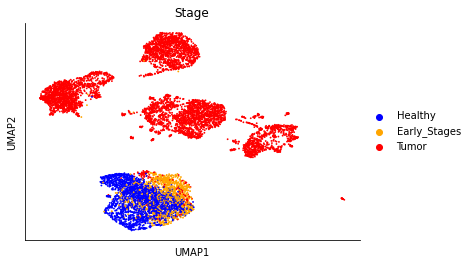

In [59]:
sc.pl.umap(adata_epi2, color = 'Stage')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


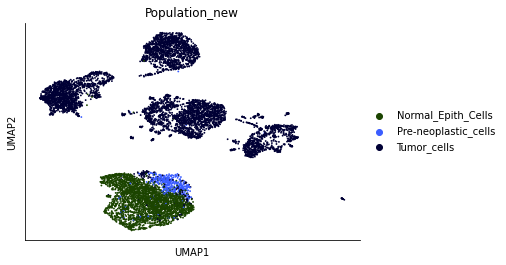

In [60]:
sc.pl.umap(adata_epi2, color = 'Population_new')

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


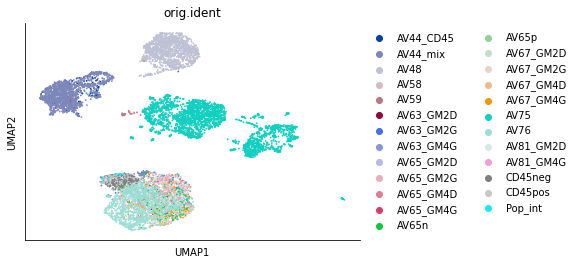

In [61]:
sc.pl.umap(adata_epi2, color = 'orig.ident')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9987739  0.99833727 0.9980815  0.99548775 0.9940272
     0.9849035  0.98118925 0.97965556 0.9794955  0.9784683  0.977665
     0.97734815 0.97445756 0.9717688 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


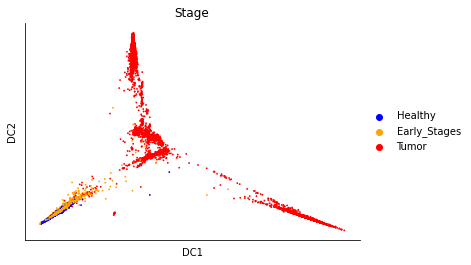

In [62]:
sc.tl.diffmap(adata_epi2)
adata_epi2.obsm["X_diffmap"] = adata_epi2.obsm["X_diffmap"][:, 2:]
sc.pl.diffmap(adata_epi2, color = "Stage")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


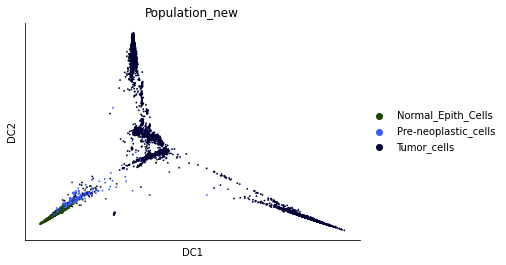

In [63]:
sc.pl.diffmap(adata_epi2, color = "Population_new")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


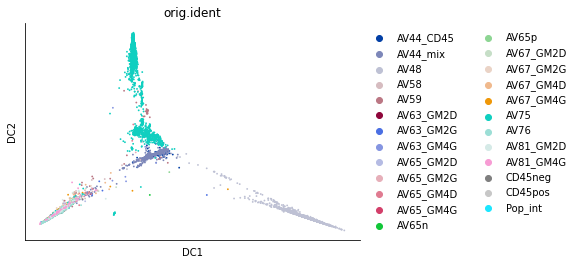

In [64]:
sc.pl.diffmap(adata_epi2, color = "orig.ident")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:01:01)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


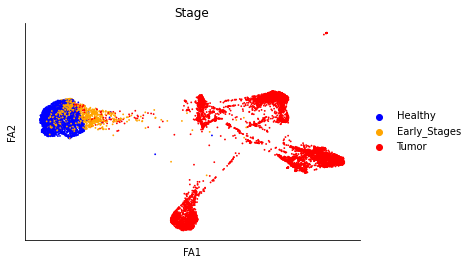

In [65]:
sc.tl.draw_graph(adata_epi2)
sc.pl.draw_graph(adata_epi2, color = 'Stage')

PAS MAL

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


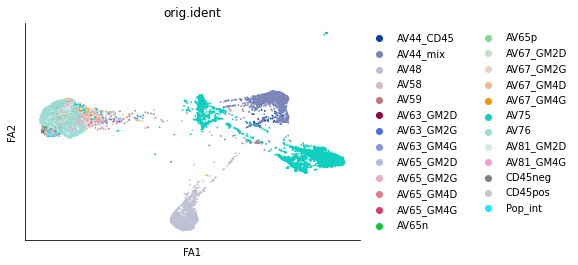

In [66]:
sc.pl.draw_graph(adata_epi2, color = 'orig.ident')

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


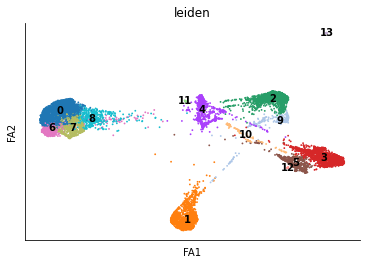

In [67]:
sc.tl.leiden(adata_epi2, resolution = 0.4)
sc.pl.draw_graph(adata_epi2, color = "leiden", legend_loc="on data")

In [68]:
sc.tl.paga(adata_epi2, groups="leiden")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


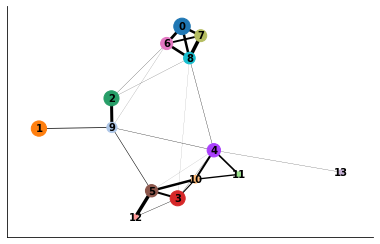

In [69]:
sc.pl.paga(adata_epi2, color='leiden')

In [70]:
adata_epi2.uns['iroot'] = np.flatnonzero(adata_epi2.obs['leiden']  == "4")[0]

In [71]:
sc.tl.dpt(adata_epi2)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


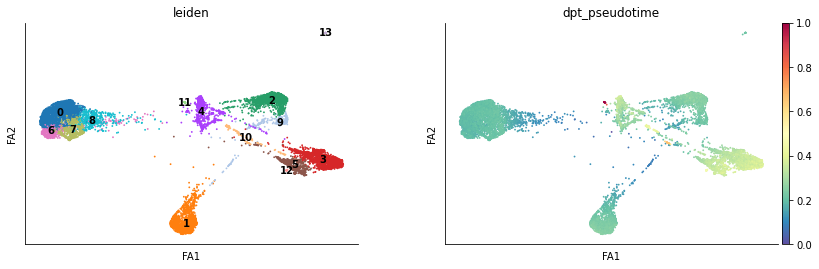

In [72]:
sc.pl.draw_graph(adata_epi2, color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

In [73]:
scf.tl.curve(adata_epi2, Nodes = 30, ndims_rep=2)

inferring a principal curve --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:02) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


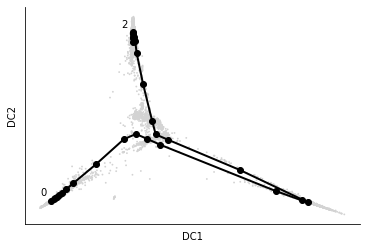

In [74]:
scf.pl.graph(adata_epi2, basis = "diffmap")

In [75]:
pca_projections = pd.DataFrame(adata_epi2.obsm["X_pca"],index=adata_epi2.obs_names)

dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

# generate neighbor draph in multiscale diffusion space
adata_epi2.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata_epi2,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [76]:
scf.tl.tree(adata_epi2,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting: 100%|██████████| 200/200 [00:04<00:00, 41.67it/s]
    not converged (error: 0.006411310693520695)
    finished (0:00:04) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


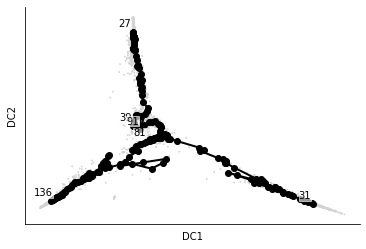

In [88]:
scf.pl.graph(adata_epi2, basis = "diffmap")

node 136 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:06) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


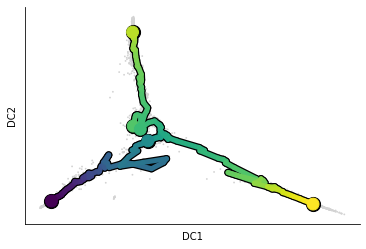

In [78]:
# Choose root cells (normal tissue)
scf.tl.root(adata_epi2, 136)

# Compute pseudotime
scf.tl.pseudotime(adata_epi2)

# Show plot
scf.pl.trajectory(adata_epi2, basis = "diffmap")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


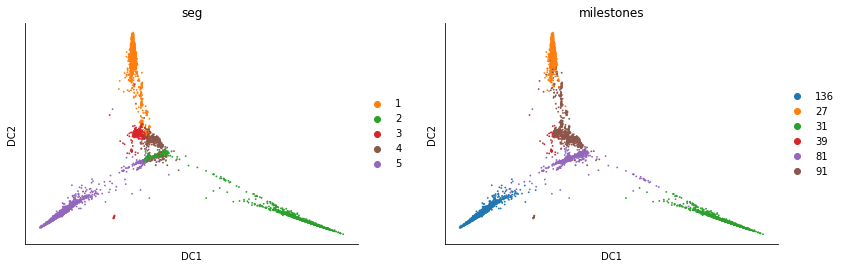

In [79]:
sc.pl.diffmap(adata_epi2,color=["seg","milestones"])

YES

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


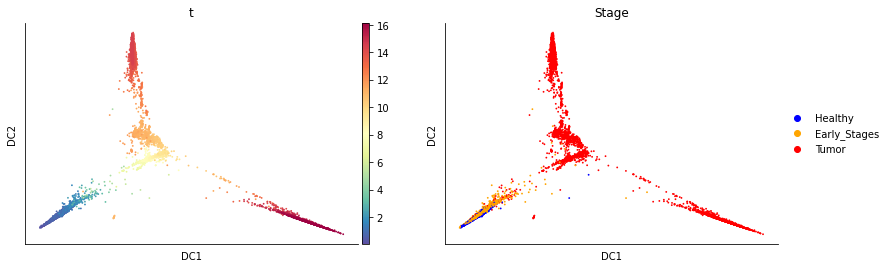

In [80]:
sc.pl.diffmap(adata_epi2, color = ["t", "Stage"])

In [ ]:
#scf.tl.fit(adata_epi2,n_jobs=20)

In [ ]:
#scf.pl.single_trend(adata_epi2,"Fos",basis="diffmap")

In [ ]:
#scf.tl.test_fork(adata_epi2,root_milestone="136",milestones=["31","27"],n_jobs=20,rescale=True)

In [ ]:
#scf.tl.branch_specific(adata_epi2,root_milestone="136",milestones=["31","27"], effect = 2)

# On va refaire proprement avec slinghsot

## Cellules épithéliales avec tumeur


In [83]:
scf.tl.curve(adata_epi, Nodes = 30, ndims_rep=2)

inferring a principal curve --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:01) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


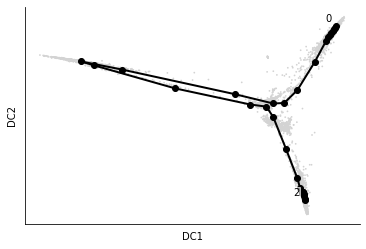

In [89]:
scf.pl.graph(adata_epi, basis = "diffmap")

In [90]:
pca_projections = pd.DataFrame(adata_epi.obsm["X_pca"],index=adata_epi.obs_names)

dm_res = palantir.utils.run_diffusion_maps(pca_projections)
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)

# generate neighbor draph in multiscale diffusion space
adata_epi.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata_epi,n_neighbors=30,use_rep="X_palantir")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [91]:
scf.tl.tree(adata_epi,method="ppt",Nodes=200,use_rep="palantir",
            device="cpu",seed=1,ppt_lambda=100,ppt_sigma=0.025,ppt_nsteps=200)

inferring a principal tree --> parameters used 
    200 principal points, sigma = 0.025, lambda = 100, metric = euclidean
    fitting:  60%|██████    | 121/200 [00:02<00:01, 42.50it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


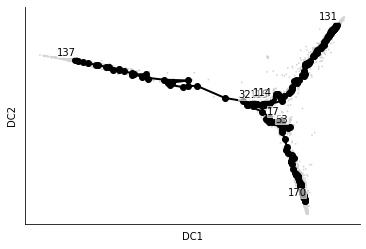

In [94]:
scf.pl.graph(adata_epi, basis = "diffmap")

node 131 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:06) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


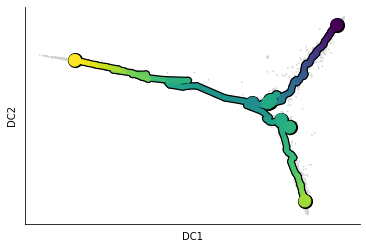

In [95]:
# Choose root cells (normal tissue)
scf.tl.root(adata_epi, 131)

# Compute pseudotime
scf.tl.pseudotime(adata_epi)

# Show plot
scf.pl.trajectory(adata_epi, basis = "diffmap")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


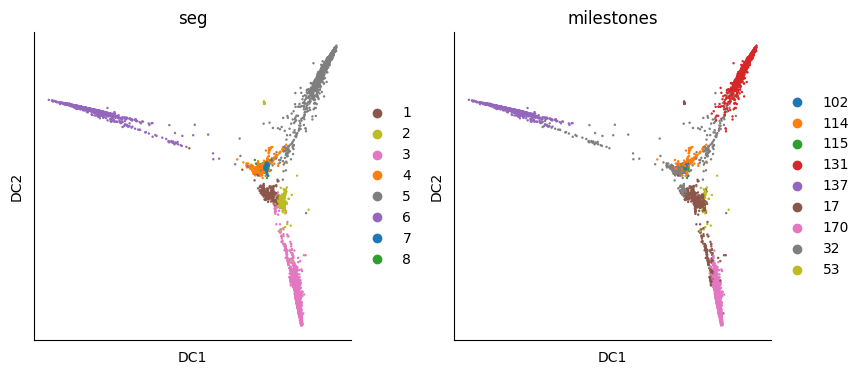

In [12]:
sc.pl.diffmap(adata_epi,color=["seg","milestones"])

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


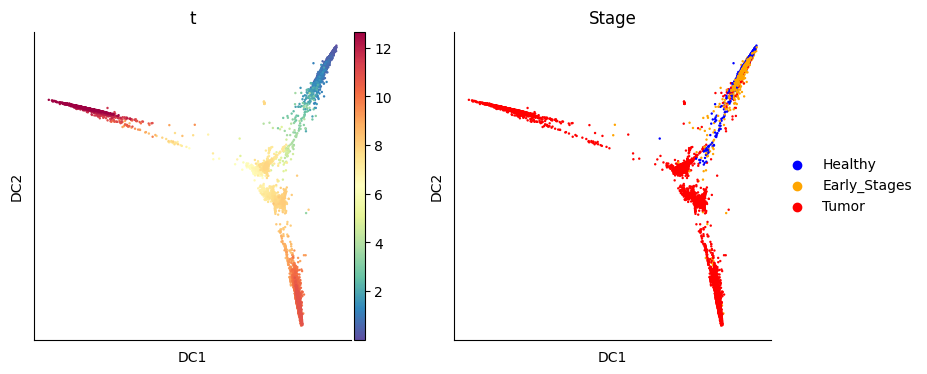

In [11]:
sc.pl.diffmap(adata_epi, color = ["t", "Stage"])

In [98]:
scf.tl.dendrogram(adata_epi)

Generating dendrogram of tree
    segment : 100%|██████████| 7/7 [01:23<00:00, 11.93s/it]
    finished (0:01:23) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


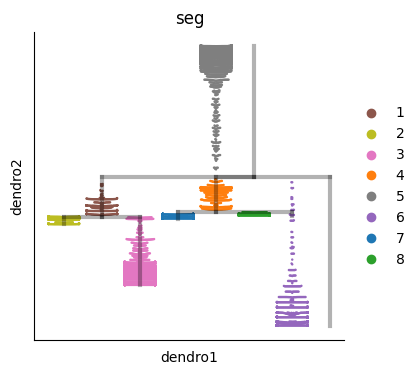

In [10]:
scf.pl.dendrogram(adata_epi,color="seg")

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


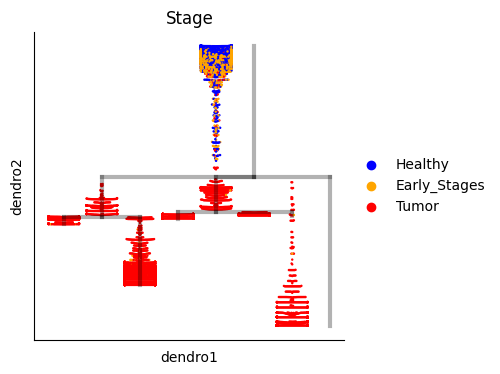

In [9]:
scf.pl.dendrogram(adata_epi,color="Stage")

A check avec les clusters inferCNV

In [101]:
scf.tl.test_association(adata_epi,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 2559/2559 [06:30<00:00,  6.55it/s]
    found 1953 significant features (0:06:30) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


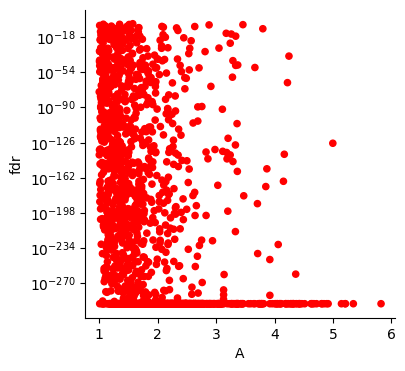

In [8]:
scf.pl.test_association(adata_epi)

In [103]:
scf.tl.fit(adata_epi,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 1953/1953 [13:08<00:00,  2.48it/s]
    finished (adata subsetted to keep only fitted features!) (0:13:14) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [14]:
# Save adata object
with open('../data/adata_epi.pickle', 'wb') as f1:
    pickle.dump(adata_epi, f1)


In [13]:
scf.tl.test_fork(adata_epi,root_milestone="131",milestones=["137", "170"],n_jobs=20,rescale=True)

testing fork
    single mapping


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scFates/tools/bifurcation_tools.py:157: FutureWarning: In a future version of pandas all arguments of Index.drop_duplicates will be keyword-only.
  brcells = brcells.loc[brcells.index.drop_duplicates(False)]


    Differential expression:   0%|                                                                          | 0/1953 [00:00<?, ?it/s]

Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rs

    Differential expression: 100%|███████████████████████████████████████████████████████████████| 1953/1953 [04:31<00:00,  7.20it/s]
    test for upregulation for each leave vs root
    upreg 170: 100%|████████████████████████████████████████████████████████████████████████████| 1192/1192 [00:02<00:00, 462.81it/s]
    finished (0:04:36) --> added 
    .uns['131->137<>170']['fork'], DataFrame with fork test results.


In [15]:
#Load saved adata object
with open('../data/adata_epi.pickle', 'rb') as f1:
     adata_epi = pickle.load(f1)

In [17]:
scf.tl.branch_specific(adata_epi,root_milestone = "131",milestones = ["137", "170"],effect = 2)

    branch specific features: 137: 11
    finished --> updated 
    .uns['131->137<>170']['fork'], DataFrame updated with additionnal 'branch' column.


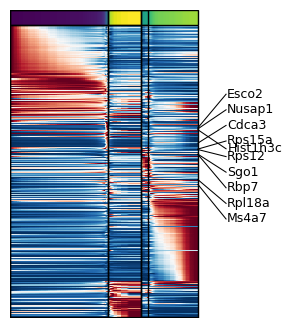

In [19]:
g1=scf.pl.trends(adata_epi,
                 root_milestone="131",
                 milestones=["137","170"],
                 brach = "137",
                 plot_emb=False,ordering="max",return_genes=True)


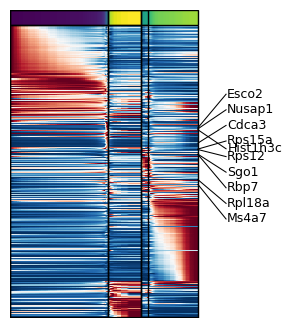

In [20]:
g2=scf.pl.trends(adata_epi,
                 root_milestone="131",
                 milestones=["137","170"],
                 brach = "170",
                 plot_emb=False,ordering="max",return_genes=True)

In [30]:
scf.tl.activation_lm(adata_epi,root_milestone="131",milestones=["137","170"],n_jobs=20)

    single mapping
    prefork activation:  73%|████████████████████████████████████████████████████▎                   | 8/11 [00:00<00:00, 118.08it/s]

Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/Library/Frameworks/R.framework/Resources/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.


    prefork activation: 100%|████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.05s/it]
    7 early and 4 late features specific to leave 137
    0 early and 0 late features specific to leave 170
    finished (0:03:52) --> updated 
    .uns['131->137<>170']['fork'], DataFrame updated with additionnal 'slope','pval','fdr','prefork_signi' and 'module' columns.


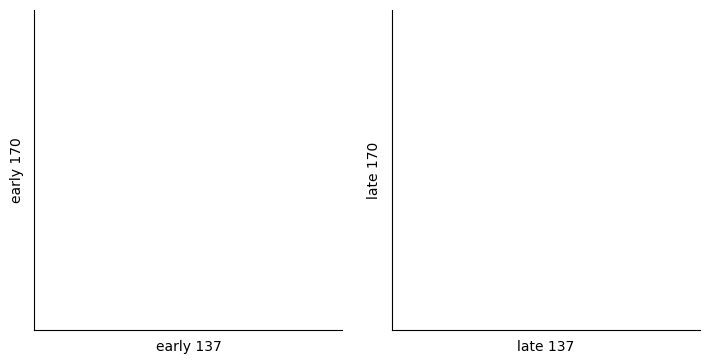

In [31]:
scf.pl.modules(adata_epi,root_milestone="131",milestones=["137","170"],
               smooth=True)

In [25]:
scf.tl.slide_cells(adata_epi,root_milestone="131",milestones=["137","170"],win=400)

scf.tl.slide_cors(adata_epi,root_milestone="131",milestones=["137","170"])

--> added 
    .uns['131->137<>170']['cell_freq'], probability assignment of cells on 27 non intersecting windows.
--> added 
    .uns['131->137<>170']['corAB'], gene-gene correlation modules.


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: Axis limits cannot be NaN or Inf

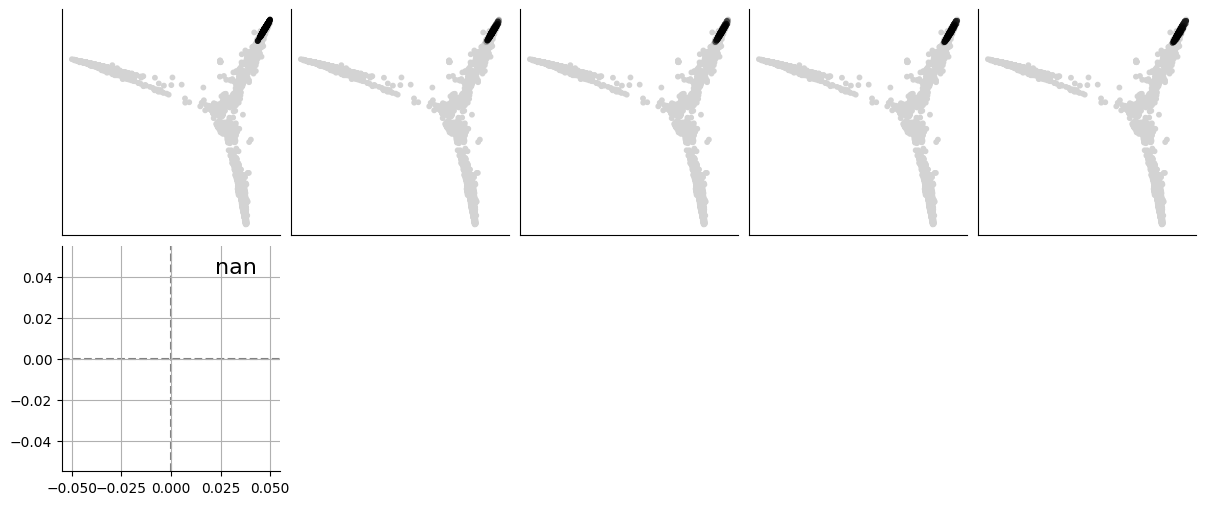

In [29]:
scf.pl.slide_cors(adata_epi,root_milestone="131",milestones=["137","170"],basis="diffmap",win_keep=[0,2,3,4,5],
                 focus=2)